# Es 1

In [ ]:
import numpy as np      
import matplotlib.pyplot as plt 
import scipy.io.wavfile 
import subprocess
import librosa
import librosa.display
import IPython.display as ipd
import os
import pickle
from collections import defaultdict, Counter
import re

from pathlib import Path, PurePath   
from tqdm import tqdm

## Settings

In [ ]:
N_TRACKS = 1413
N_QUERYS = 10
HOP_SIZE = 512
OFFSET = 0
DURATION = 600
THRESHOLD = 0
BAND_SIZE = 10
PERMUTATIONS = 300
SEED = 26
MOD = 1423

In [ ]:
#path variables
data_folder = Path("./mp3s-32k/")
mp3_tracks = data_folder.glob("*/*/*.mp3")
tracks = data_folder.glob("*/*/*.wav")

## Utility functions

In [ ]:
def convert_mp3_to_wav(audio:str) -> str:  
    """Convert an input MP3 audio track into a WAV file.

    Args:
        audio (str): An input audio track.

    Returns:
        [str]: WAV filename.Spero che siate aggiornati sulla stagione UK???? ￼￼￼￼￼
    """
    if audio[-3:] == "mp3":
        wav_audio = audio[:-3] + "wav"
        if not Path(wav_audio).exists():
                subprocess.check_output(f"ffmpeg -i {audio} {wav_audio}", shell=True)
        return wav_audio
    
    return audio

def plot_spectrogram_and_peaks(track:np.ndarray, sr:int, peaks:np.ndarray, onset_env:np.ndarray) -> None:
    """Plots the spectrogram and peaks 

    Args:
        track (np.ndarray): A track.
        sr (int): Aampling rate.
        peaks (np.ndarray): Indices of peaks in the track.
        onset_env (np.ndarray): Vector containing the onset strength envelope.
    """
    times = librosa.frames_to_time(np.arange(len(onset_env)),
                            sr=sr, hop_length=HOP_SIZE)

    plt.figure(figsize=(15,10))
    ax = plt.subplot(2, 1, 2)
    D = librosa.stft(track)
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(D), ref=np.max),
                            y_axis='log', x_axis='time')
    plt.subplot(2, 1, 1, sharex=ax)
    plt.plot(times, onset_env, alpha=0.8, label='Onset strength')
    plt.vlines(times[peaks], 0,
            onset_env.max(), color='r', alpha=0.8,
            label='Selected peaks')
    plt.legend(frameon=True, framealpha=0.8)
    plt.axis('tight')
    plt.tight_layout()
    plt.show()

def load_audio_peaks(audio, offset, duration, hop_size):
    """Load the tracks and peaks of an audio.

    Args:
        audio (string, int, pathlib.Path or file-like object): [description]
        offset (float): start reading after this time (in seconds)
        duration (float): only load up to this much audio (in seconds)
        hop_size (int): the hop_length

    Returns:
        tuple: Returns the audio time series (track) and sampling rate (sr), 
        a vector containing the onset strength envelope
        (onset_env), and the indices of peaks in track (peaks).
    """
    try:
        track, sr = librosa.load(audio, offset=offset, duration=duration)
        onset_env = librosa.onset.onset_strength(track, sr=sr, hop_length=hop_size)
        peaks = librosa.util.peak_pick(onset_env, 10, 10, 10, 10, 0.5, 0.5)
    except Error as e:
        print('An error occurred processing ', str(audio))
        print(e)

    return track, sr, onset_env, peaks
    
    

## Minhash

### Building the signatures of the tracks

Computing longest track duration:

In [ ]:
#computing the track duration from the first element of the dataset
tracks = sorted(data_folder.glob("*/*/*.wav"), key=os.path.getsize) # sorting tracks by size
_, sr, onset_env, _ = load_audio_peaks(tracks[-1], OFFSET, DURATION, HOP_SIZE) #input longest track
TrackDuration = librosa.frames_to_time(np.arange(len(onset_env)), sr=sr, hop_length=HOP_SIZE) #max size track duration

The method used to compute the minhash value of each track is:
1) Extraxt audio peaks
2) A  ShingleArray is build, it represents the track only with it's peaks:
    - The track is an array of zeros and ones 
    - Each array element represents a given moment in time
    - Ones represent peaks, and so the elements of the array are all zeros except at the moment in which a peak was computed
3) The elements of the array are randomly permuted #PERMUTATOINS times; the seed of the permuting algorithm is initialized for each track
4) At each permutation the index of the first non zero element is recorded in the SignatureArray of the track to guarantee conformity
5) Each track is assigned an ID, the correspondance ID - track_path is recorded in a dictionary; this dictionay is dumped to a file to be recalled without re-running the code 
6) The ShingleArray and the SignatureArray are stored in a the ShingleMatrix and the SignatureMatrix with the columns corresponding to the track ID; this matrixes are dumped to a file to be recalled without re-running the code 

In [ ]:
#redefining tracks to re-start from the first element of tracks generator
tracks = data_folder.glob("*/*/*.wav")

#dictionary to associate track ID row with it's path
IDofTrack = dict()

#defining the SignatureArray
SignatureMatrix = np.empty((PERMUTATIONS, N_TRACKS), dtype=int) #row index: permutation number, column index: ID
ShingleMatrix = np.empty((len(TrackDuration), N_TRACKS), dtype=int) #row: time instant, column index: ID

#buiding the shingle matrix and the first row of the signature matrix
for ID, audio in enumerate(tqdm(tracks, total=N_TRACKS)):
    AudioPath = '/'.join(os.path.abspath(audio).split('/')[-3:]) #formatting the path to have only essential info
    IDofTrack[ID] = AudioPath
    _, _, _, peaks = load_audio_peaks(audio, OFFSET, DURATION, HOP_SIZE) #computing peak indexes
    
    #buiding a Shingle array
    ShingleArray =  np.zeros(len(TrackDuration), dtype=int)
    for PeakIdx in peaks:
        ShingleArray[PeakIdx] = 1
    ShingleMatrix[:, ID] = ShingleArray
    
    #permuting the shingle array and recording it's the first non null element in the SignatureArray
    #initializing the random number generator to obtain consistent permutations across all tracks
    rng = np.random.default_rng(SEED) 
    for i in range(PERMUTATIONS):
        ShuffledShingleArray = rng.permutation(ShingleArray)
        SignatureMatrix[i][ID] = ShuffledShingleArray.argmax()
        
#storing the computed matrixes
with open('ShingleMatrix', 'wb') as f:
    pickle.dump(ShingleMatrix, f)
with open('SignatureMatrix', 'wb') as f:
    pickle.dump(SignatureMatrix, f)
with open('IDofTrack', 'wb') as f:
    pickle.dump(IDofTrack, f)

Importing SignatureMatrix and IDofTracks instead of running minhash code:

In [ ]:
pickle_SignatureMatrix = open('SignatureMatrix', "rb")
SignatureMatrix = pickle.load(pickle_SignatureMatrix)

pickle_IDofTrack = open('IDofTrack', "rb")
IDofTrack = pickle.load(pickle_IDofTrack)

### Hashing

The algorithm below is a basic hashing function. 
1) The elements of the input array are multiplied to a random number
2) They are then summed
3) The output is the reminder of the division by MOD

MOD is the closest prime number to N_TRACKS, this condition limits random collisions, i.e. the hashed elements will be almost equally distributed through the #MOD bins

In [ ]:
def HashFunction(Shingle):
    np.random.seed(SEED)
    c = np.array([np.random.randint(MOD) for i in range(BAND_SIZE)])
    return np.multiply(Shingle, c).sum() % MOD

A bag method is used for bucketing:
1) The SignatureArray of each track is divided in to arrays of lenght BAND_SIZE; we refer to those array as tokens, a track is now represented through the set of it's tokens
2) The hash values of this tokens are computed through the hash function
3) A dictionary is build:
    - it's keys are the hash value of a given token
    - the values of the keys are the buckets containing the track ID's in which have the corresponding token
    - this values are counters that store the number of occurences of the token of each track

In [ ]:
def BucketingShingles():
    ShingleBuckets = defaultdict(Counter)
    #hashing the audio track using as keys it's signatures grouped in bands of size BAND_SIZE
    for ID in range(N_TRACKS):
        for i in range(0, PERMUTATIONS, BAND_SIZE):   
            Shingle = SignatureMatrix[:, ID][i:(i+BAND_SIZE)]
            BucketKey = HashFunction(Shingle)
            ShingleBuckets[str(BucketKey)][ID] +=1
    return(ShingleBuckets)

### Querying

The minhash method was used to process the querys in the same manner as the dataset.
<br>
<br>

For each token of the query the corresponding bucket is retrived. It is remainded that this bucket contains the tracks that contained the token, associated with the number of occurences of that token.\
A TrackSimilarities counter is now used to store the number of occurences of the tracks of all the query tokens. This method de facto groups the tracks and it's number of occurences contained in all the buckets to which the query belongs.\
The tracks with most occurances are then retrieved from the TrackSimilarities dictionary to make a comparision of the respective SignatureArrays with the query. The number of similarities divided by the number of array elements will be the Jaccard Similiraity of the tracks.

As defined in Mining of Massive Datasets by Jure Leskovec the threshold $T$ is the value of similarity $JS$ at which the probability of becoming a candidate is $1/2$. Conforming to the book notation:
- $b$ = `#BANDS`
- $r$ = `BAND_SIZE`

with `#BANDS = PERMUTATIONS / BAND_SIZE` that is:
- $b$ = `PERMUTATIONS` / $r$

An approximation to the threshold is $(\frac{1}{r})^{1 / b}$.
<br>
<br>

The output of the following function `EvaluateQuerys()` code cell prints:
- the query track itself. This was checked by a direct audio comparison of the audio of the query and the best match
- the second best match with it's Jaccard Similarity score

In [ ]:
def EvaluateQuerys():
    #defing path variables
    query_folder = Path("./querys")
    querys = sorted(query_folder.glob("*.wav"), key=os.path.getmtime)

    #buiding the shingle matrix and the first row of the signature matrix
    for ID, audio in enumerate(querys):
        # if ID < 1:
        AudioPath = os.path.abspath(audio).split('/')[-1] #formatting the path to have only essential info
        _, _, _, peaks = load_audio_peaks(audio, OFFSET, DURATION, HOP_SIZE) #computing peack indexes

        #buiding a Shingle array
        ShingleArray =  np.zeros(len(TrackDuration), dtype=int)
        for PeakIdx in peaks:
          ShingleArray[PeakIdx] = 1

        #defining the SignatureArray
        SignatureArray = np.empty(PERMUTATIONS, dtype=int)

        #permuting the shingle array and recording it's the first non null element in the SignatureArray
        #initializing the random number generator to obtain consistent permutations across all tracks
        rng = np.random.default_rng(SEED) 
        for i in range(PERMUTATIONS):
            ShuffledShingleArray = rng.permutation(ShingleArray)
            SignatureArray[i] = ShuffledShingleArray.argmax()

        #hashing the audio track using as keys it's signatures grouped in bands of size BAND_SIZE
        #storing the hashes in a list to retrieve the buckets to which the query belongs
        QueryBuckets = np.empty(0, dtype=int)
        for i in range(0, PERMUTATIONS, BAND_SIZE):
            Shingle = SignatureArray[i:(i+BAND_SIZE)]
            BucketKey = HashFunction(Shingle)
            QueryBuckets = np.append(QueryBuckets, BucketKey)

        #interection of buckets to which the query belongs
        # IntersectionElements = [*set.intersection(*[ShingleBuckets[key] for key in QueryBuckets[:3]])]
        TrackSimilarities = Counter()
        for q in QueryBuckets:
            TrackSimilarities.update(ShingleBuckets[str(q)])

        #track is...
        #print bucket elements to which the query belongs
        QueryName = AudioPath.split('.')[0]
        # for element in IDofTrack[TrackSimilarities.most_common()[0][0]]:
        track = IDofTrack[TrackSimilarities.most_common()[0][0]]
        #formatting
        Title = track.split('/')[-1][:-4].replace('_', ' ')
        Title = re.sub(r'[\d^-]', '', Title)
        Album = track.split('/')[1].split('_')
        Album = ' '.join([name.capitalize() for name in Album])
        Author = track.split('/')[0].split('_')
        Author = ' '.join([name.capitalize() for name in Author])
        QueryNameAlligned = str.center(AudioPath.split('.')[0] + ':', (13 + len(QueryName)))
        print(f'{QueryNameAlligned}{Author} - {Title} ({Album})')

        #most similar track has Jaccard similarity
        IDFirstSimilarity = TrackSimilarities.most_common()[0][0]
        IDSecondSimilarity = TrackSimilarities.most_common()[1][0]

        track = IDofTrack[TrackSimilarities.most_common()[1][0]]
        #formatting
        Title = track.split('/')[-1][:-4].replace('_', ' ')
        Title = re.sub(r'[\d^-]', '', Title)
        Album = track.split('/')[1].split('_')
        Album = ' '.join([name.capitalize() for name in Album])
        Author = track.split('/')[0].split('_')
        Author = ' '.join([name.capitalize() for name in Author])

        JaccardSimilarity = sum(SignatureMatrix[:, IDFirstSimilarity] == \
                                SignatureMatrix[:, IDSecondSimilarity]) / PERMUTATIONS
        print(f'{QueryName} best match: {Author} - {Title} ({Album}) with JS of {JaccardSimilarity: .3f}\n')

In the first example the parameers used are:
- `PERMUTATIONS` = 300
- `BAND_SIZE` = 3

and so:\
$b = 300 / 3 = 100$ \
$T = 0.215$

In [ ]:
BAND_SIZE = 3
PERMUTATIONS = 300
ShingleBuckets = BucketingShingles()
EvaluateQuerys()

      track1:      Aerosmith - Dream On (Aerosmith)
track1 best match: Beatles - Baby s In Black (Beatles For Sale) with JS of  0.023

      track2:      Queen - I Want To Break Free (The Works)
track2 best match: Suzanne Vega - Small Blue Thing (Suzanne Vega) with JS of  0.030

      track3:      U2 - October (October)
track3 best match: Metallica - Bleeding Me (Load) with JS of  0.010

      track4:      Beatles - ObLaDi ObLaDa (The White Album Disc 1)
track4 best match: U2 - Love Is Blindness (Achtung Baby) with JS of  0.023

      track5:      Radiohead - Karma Police (Ok Computer)
track5 best match: Green Day - Dominated Love Slave (Kerplunk) with JS of  0.007

      track7:      Fleetwood Mac - Go Your Own Way (Rumours)
track7 best match: Green Day - Jinx (Nimrod) with JS of  0.017

      track8:      Green Day - American Idiot (American Idiot)
track8 best match: Radiohead - I Might Be Wrong (Amnesiac) with JS of  0.013

      track6:      Led Zeppelin - Heartbreaker (Led Zeppeli

Now the parameers are:
- `PERMUTATIONS` = 300
- `BAND_SIZE` = 10

and so:\
$b = 300 / 10 = 30$ \
$T = 0.712$

In [ ]:
BAND_SIZE = 10
PERMUTATIONS = 300
ShingleBuckets = BucketingShingles()
EvaluateQuerys()

      track1:      Aerosmith - Dream On (Aerosmith)
track1 best match: Garth Brooks - I ve Got A Good Thing Going (Garth Brooks The Limited Series ) with JS of  0.023

      track2:      Queen - I Want To Break Free (The Works)
track2 best match: U2 - Running to Stand Still (The Joshua Tree) with JS of  0.027

      track3:      U2 - October (October)
track3 best match: Dave Matthews Band - Don t Drink the Water (Before These Crowded Streets) with JS of  0.000

      track4:      Beatles - ObLaDi ObLaDa (The White Album Disc 1)
track4 best match: Fleetwood Mac - Over My Head (Fleetwood Mac) with JS of  0.020

      track5:      Radiohead - Karma Police (Ok Computer)
track5 best match: Fleetwood Mac - Walk a Thin Line (Tusk) with JS of  0.013

      track7:      Fleetwood Mac - Go Your Own Way (Rumours)
track7 best match: Metallica - Metal Militia (Kill Em All) with JS of  0.017

      track8:      Green Day - American Idiot (American Idiot)
track8 best match: Cure - The Snakepit (Kiss 

Now the parameers are:
- `PERMUTATIONS` = 150
- `BAND_SIZE` = 5

and so:\
$b = 150 / 5 = 30$ \
$T = 0.507$

In [ ]:
BAND_SIZE = 5
PERMUTATIONS = 150
SignatureMatrix = SignatureMatrix[:150]
ShingleBuckets = BucketingShingles()
EvaluateQuerys()

      track1:      Aerosmith - Dream On (Aerosmith)
track1 best match: Suzanne Vega - Song Of Sand (99 9 F ) with JS of  0.020

      track2:      Queen - I Want To Break Free (The Works)
track2 best match: Madonna - Bye Bye Baby (Erotica) with JS of  0.073

      track3:      U2 - October (October)
track3 best match: Green Day - King For A Day (Nimrod) with JS of  0.013

      track4:      Beatles - ObLaDi ObLaDa (The White Album Disc 1)
track4 best match: Radiohead - I Will (Hail To The Theif) with JS of  0.000

      track5:      Radiohead - Karma Police (Ok Computer)
track5 best match: Queen - Keep Passing The Open Windows (The Works) with JS of  0.013

      track7:      Fleetwood Mac - Go Your Own Way (Rumours)
track7 best match: Radiohead - A Wolf at the Door (Hail To The Theif) with JS of  0.027

      track8:      Green Day - American Idiot (American Idiot)
track8 best match: Cure - Bare (Wild Mood Swings) with JS of  0.013

      track6:      Led Zeppelin - Heartbreaker (Led 

Different combinations of the band size and the number of permutations gave different similarities of the querys but a significant variation of the $JS$ is not observed. \
The result could be imporved with:
- expanding the dataset, this would allow to have more shingles and more probability of similarities between them
- adding some "noise" to the peaks, de facto "spreading" the peaks over more array elements so to loosen the constrain that the peaks of the tracks should precisely match

# Es 2

## Es 2.1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
echo = pd.read_csv('/content/drive/MyDrive/ADM_HM4/echonest.csv')

In [ ]:
feat = pd.read_csv('/content/drive/MyDrive/ADM_HM4/features.csv')

In [ ]:
tracks = pd.read_csv('/content/drive/MyDrive/ADM_HM4/tracks.csv')

In [ ]:
# Just a look on the dataframes dimensions
print(echo.shape)
print(feat.shape)
print(tracks.shape)

(13129, 250)
(106574, 519)
(106574, 53)


In [ ]:
# Merging "echo" and "feat" dataframes (cause merge function wants only two dataframes)
df1 = pd.merge(echo,feat, on = 'track_id')

In [ ]:
# Create the final dataframe
df = pd.merge(df1,tracks, on = 'track_id')

In [ ]:
df.shape

(13129, 820)

### Preprocessing the dataset

Cleaning all features with too many "na" values (all the ones with more than 10%)

In [ ]:
df = df.dropna(axis=1,thresh=int(0.9*df.shape[0]))  ## drop all columns with more than 10% of nan value

In [ ]:
dfna = df.fillna(np.NaN)    #this will be used for the Cluster-Analysis
df = df.fillna(0)           #this will be used for the PCA

In [ ]:
# Checking if it contains near 13000 rows
print(dfna.shape)
print(df.shape)

(13129, 788)
(13129, 788)


## Es 2.2


To reduce the dimensionality of features in our dataset we choose to use the Principal Component Analysis. This method allow us to create a certain number of Principal Components in order to obtain a dataframe with less features but many explained information as we want. For this exercise we set the information that we want preserved equal at least at 70%. To work on our dataset in order to create the right principal components we need to standradize each feature (if we don't, features with different scales may create some problem in the principal component creation). The problem with this method is that we can apply it only on numeric features so, as we can see in the final dataframe, we remain with a lot of features.

In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [ ]:
typo = dict(df.dtypes)

In [ ]:
# Create two list with respectively the names of float and non-float variables
features = list()
target = list()
for f in typo:
  if typo[f] == 'float64':
    features.append(f)
  else:
    target.append(f)

In [ ]:
fe = df.select_dtypes(include=['float64']) #only float

In [ ]:
# Create correlation matrix
corr_matrix = fe.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features 
fe.drop(to_drop, axis=1, inplace=True)

In [ ]:
fe.shape

(13129, 644)

In [ ]:
# Creates two arrays with the values respectively of float variables and non-float variables
x = fe.values
y = df.loc[:,target].values

In [ ]:
# Standardize numeric variables
x = StandardScaler().fit_transform(x)

In [ ]:
colx = ['PC' + str(i) for i in range(1,70)]

In [ ]:
# Principal Component Analysis; we create 69 new variables from the original 780
pca = PCA(n_components=69)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns=colx)

In [ ]:
# Creates a dataframe with our Principal Components and old non-float variables
finalDf = pd.concat([principalDf, pd.DataFrame(y, columns=target)], axis = 1)

In [ ]:
# Checks if the explained data is near 70%
sum(pca.explained_variance_ratio_)

0.6947323384133492

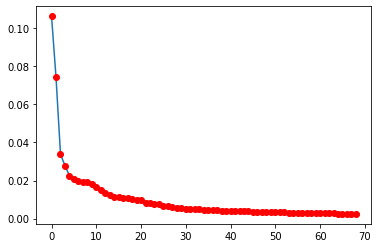

In [ ]:
#Just a visual check to see how much explained variance is in each PC
plt.plot(pca.explained_variance_ratio_)
plt.plot(pca.explained_variance_ratio_, 'ro')

Looking at the plot we see that most of our info is contained in just our first ten principal component but they are not enough to reach our goal of 70% of explained information

In [ ]:
#finalDf.to_csv('/content/drive/MyDrive/pca_data.csv')

## Es 2.3

### Es 2.3.1

K-means algorithm

In [ ]:
import random
import numpy as np

def calc_centroids(cluster,length):
  cluster=np.array(cluster)
  sum_coord = [np.sum(cluster[:,i])/len(cluster) for i in range(length)]
  return sum_coord

def k_means(dt,k):
  centroids=[] # list that contains centroids
  rand=[] # list that contains the index founded 
  # find centroids from the points given, avoiding replicant
  while len(centroids) != k:
    rand_ind=random.randint(0,len(dt)-1)
    if rand_ind not in rand:
      rand.append(rand_ind)
      centroids.append(dt[rand_ind])
  centroids=np.array(centroids)
  clusters=np.array([0 for i in range(len(dt))]) # for each element (indicated by the index), we have the correspondent cluster
  changed=True # boolean to check if something is changed during the last iteration
  # until it converges --> clusters doesn't change during the last iteration
  iterations=0
  while changed and iterations<300:
    points_in_cl=[[] for i in range(k)] #list that contains the lists of points in each cluster
    changed=False 
    # find the cluster for each point
    for p in range(len(dt)):
      min=100000
      clu=-1
      for i in range(len(centroids)):
        # calculate the distance between the point and each centroid and find the min
        dist= np.linalg.norm(dt[p]-centroids[i]) 
        if dist < min:
          min=dist
          clu=i
      points_in_cl[clu].append(dt[p]) #add the point in the founded cluster
      if clu!=clusters[p] and clu!=-1: #if there is a change
        clusters[p]=clu 
        changed=True
    # Compute new centroids for each cluster finding the average
    for c in range(k):
      centroids[c]=calc_centroids(points_in_cl[c],len(dt[0]))
    iterations+=1
  return centroids,clusters,points_in_cl

An example of application to a simple group of points 

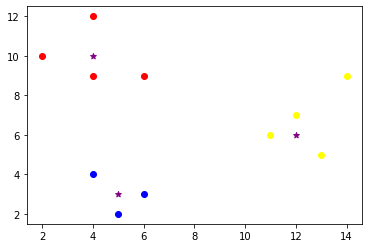

In [ ]:
from matplotlib import pyplot as plt
dt=[[2,10],[4,4],[4,9],[4,12],[5,2],[6,3],[6,9],[11,6],[12,7],[13,5],[14,9]]
centroids,clusters,points_in_cl = k_means(dt,3)
plt.scatter(list(zip(*points_in_cl[0]))[0],list(zip(*points_in_cl[0]))[1],color='blue') #first cluster
plt.scatter(list(zip(*points_in_cl[1]))[0],list(zip(*points_in_cl[1]))[1],color='red')   #second cluster
plt.scatter(list(zip(*points_in_cl[2]))[0],list(zip(*points_in_cl[2]))[1],color='yellow') #third cluster
plt.scatter(list(zip(*centroids))[0],list(zip(*centroids))[1],color='purple',marker='*')  #centroids for each cluster

As we can see our algorithm works well and divides the points in the correct clusters

### Es 2.3.2

#### Elbow method

The elbow method calculates for each execution of the k-means with different number of clusters, the sum of all the distances between each centroid and the sample in the correspondent cluster (the one where the centroid is calculated).

After doing that it has the sum of squared errors (distances) for the range of the number of clusters we chose. Plotting this value, we can see from the graph where it forms an elbow (from here the name of the method), and there the correspondent value of k is the best number of clusters.


In [ ]:
from matplotlib import pyplot as plt

def elbow_method(dataset):
  sse=[] # list that will contain the sum of squared errors for each k
  for num_clusters in range(1,10):
    sum_dist=0
    centroids,clusters,points_in_cl=k_means(dataset,num_clusters) # apply k-means algorithm with every k
    for i in range(len(centroids)):
      for point in points_in_cl[i]:
        sum_dist+=np.linalg.norm(point-centroids[i]) # calcuate the sse for each point from the centroids
    sse.append(sum_dist) 
  
  plt.xlabel('K')
  plt.ylabel('Sse')
  plt.plot(range(1,10),sse) 


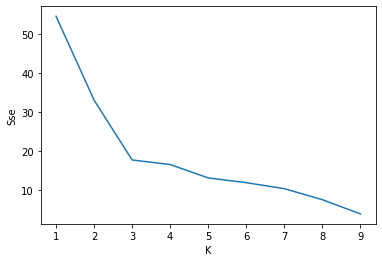

In [ ]:
elbow_method(dt)

The best number of cluster is the point where the graph looks like an elbow , so in this case 3

#### Silhouette method

The silhouette method calculate for each sample the mean distance between it and all the other sample in the cluster (mean intra-cluster distance, called a) and with the samples in the nearest cluster (mean nearest-cluster distance, called b).
After computing that, we can apply this formula to obtain the silhouette score of each sample(${S_i}$): 

${S_i} = \frac{b(i)-a(i)}{min(a(i),b(i))} $

To compute the silhouette value for the whole dataset we just need to compute the mean between all the silhouette scores we obtained; and this is a measure of how appropriately the data have been clustered.

To see which number of cluster is the best, the only thing we need to do is the value of k where we find the highest value.


In [ ]:
def silhouette_method(dataset):
  silhouette=[0,] #with k=1 the silhouette score is 0
  for num_clusters in range(2,10):
    centroids,clusters,points_in_cl=k_means(dataset,num_clusters) #operate the k_means with that number of cluster
    centroids=np.array(centroids)
    clusters=np.array(clusters)
    points_in_cl=np.array(points_in_cl)

    # for each cluster find the nearest one
    nearest=[]
    for c in range(len(centroids)):
      distances=np.linalg.norm(centroids-centroids[c], axis=1) #calculate the distances between all the centroids and this one
      nearest.append(np.where(distances==np.sort(distances)[1])[0][0]) #select the second minimum because the first one results obviously to be the centroid we are analyzing it self.
    
    ### compute the silhuette score for each sample
    scores=[]
    for cl in range(len(points_in_cl)):
      for sample in points_in_cl[cl]:
        if len(points_in_cl[cl])>1:
          # mean intra-cluster distance (a) --> the mean distance between the sample and all other samples in the same cluster 
          a = sum(np.linalg.norm(points_in_cl[cl]-np.array(sample), axis=1))/(len(points_in_cl[cl])-1) # in the counting we don't count the sample we are analyzing
          # mean nearest-cluster distance (b) --> the mean distance between the sample and all the other samples in the nearest cluster
          b= np.linalg.norm(points_in_cl[nearest[cl]]-np.array(sample), axis=1).mean()
          silhouette_score= (b-a) / (max(a,b)) #apply the silhouette score formula
          scores.append(silhouette_score) 
        else:
          scores.append(0) # if the len of the sample's cluster is 1, we have 0 as silhouette score
    scores=np.array(scores)
    silhouette.append(scores.mean()) # the silhouette score of the dataset is given by the mean of the scores of all samples.
  return silhouette
    





In [ ]:
silhouette_method(dt)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


[0,
 0.5049519138073264,
 0.6507189379210274,
 0.3547396133972357,
 0.4795140710146292,
 0.1997560259300051,
 0.14865058489812497,
 0.0972285192332282,
 0.03341313345148401]

The higher the better, so the best in this case is k=3, same as the results gave us by the elbow method

Comparing with the silhouette method implemented in scikit-learn library:

In [ ]:
from sklearn.metrics import silhouette_score

silhouette=[0,] #with k=0 the silhouette score is 0
for num_clusters in range(2,10):
    centroids,clusters,points_in_cl=k_means(dt,num_clusters)  
    silhouette_avg = silhouette_score(dt, clusters) # calculate the silhouette score (the average between each silhouette coefficient related by samples)
    silhouette.append(silhouette_avg)
print(silhouette)

[0, 0.5049519138073264, 0.6484344867124575, 0.4487355788570308, 0.21939267386012096, 0.12090687985229619, 0.24256008105688942, 0.0972285192332282, 0.11690559533704575]


As we can see, our method and the one already implemented in the library gave us quite similar results. And also in this case 3 results to be the best number of cluster on this testing small group of points

### Es 2.3.3 

Run our k-means on the dataset we got from dimensionality reduction

In [ ]:
finalDf.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,...,PC63,PC64,PC65,PC66,PC67,PC68,PC69,track_id,metadata_artist_name,metadata_release,album_comments,album_date_created,album_favorites,album_id,album_listens,album_tags,album_title,album_tracks,album_type,artist_comments,artist_date_created,artist_favorites,artist_id,artist_name,artist_tags,set_split,set_subset,track_bit_rate,track_comments,track_date_created,track_duration,track_favorites,track_genres,track_genres_all,track_interest,track_license,track_listens,track_number,track_tags,track_title
0,1.674331,-4.171082,4.643930,3.101041,1.237197,-1.235651,-1.490631,1.750588,-1.935179,2.729076,-8.901085,2.646590,0.492782,2.965413,-0.883830,0.567541,1.673673,0.132202,0.926611,1.013331,-3.219948,-2.523829,-0.806307,-3.256932,-0.141150,2.022908,0.162494,0.274174,-2.833987,0.601799,-1.491798,-0.598230,0.262901,-2.133528,0.026452,-1.764289,2.517017,0.527012,0.527675,-2.056041,...,1.176270,0.697209,0.513274,0.128583,0.733864,-0.227831,-0.338472,2,AWOL,AWOL - A Way Of Life,0,2008-11-26 01:44:45,4,1,6073,[],AWOL - A Way Of Life,7,Album,0,2008-11-26 01:42:32,9,1,AWOL,['awol'],training,small,256000,0,2008-11-26 01:48:12,168,2,[21],[21],4656,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,3,[],Food
1,2.682865,-7.195443,3.545126,-0.677019,-2.293912,2.102304,3.441812,-1.482769,4.119562,4.545121,-4.573650,3.170868,-0.929997,0.815888,-1.908554,-0.058188,2.794149,0.115730,-2.358954,-1.816059,0.014982,-1.156188,0.193136,-3.743543,1.383235,-0.614957,1.312367,0.187896,-1.383633,1.806082,0.378054,-0.479969,-0.380615,0.280302,-0.124268,0.318010,1.505638,-0.500109,2.065090,-1.035610,...,-0.884523,0.826654,2.226573,-0.978864,-1.731191,0.138992,-0.642800,3,AWOL,AWOL - A Way Of Life,0,2008-11-26 01:44:45,4,1,6073,[],AWOL - A Way Of Life,7,Album,0,2008-11-26 01:42:32,9,1,AWOL,['awol'],training,medium,256000,0,2008-11-26 01:48:14,237,1,[21],[21],1470,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,4,[],Electric Ave
2,0.780689,-5.159503,3.179270,-1.070108,-2.799030,0.722573,2.579771,-0.905533,-0.697416,1.648018,-3.478698,3.984546,-0.582571,1.363179,-2.183392,-1.008869,0.708474,1.824795,-1.556202,2.138284,-2.143009,1.109319,1.164982,-3.281510,0.388760,0.961912,1.611757,1.052660,-1.575714,0.365732,1.721584,-0.955026,0.249969,-1.263937,-1.208098,-0.445513,0.422621,1.909406,-0.613357,0.020027,...,-0.298101,0.972247,0.681456,-0.078355,0.442119,-0.246298,0.369394,5,AWOL,AWOL - A Way Of Life,0,2008-11-26 01:44:45,4,1,6073,[],AWOL - A Way Of Life,7,Album,0,2008-11-26 01:42:32,9,1,AWOL,['awol'],training,small,256000,0,2008-11-26 01:48:20,206,6,[21],[21],1933,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,6,[],This World
3,9.330128,-0.838479,4.323413,1.003613,-0.547969,-0.684255,2.761180,-0.739595,2.261340,2.680096,-3.473370,5.093121,0.754046,-5.432345,-1.375006,0.084090,0.057978,-3.497529,-0.133628,3.420857,-0.203062,-3.311435,1.763107,1.438211,-0.354666,0.638886,0.287967,0.010785,2.353479,-2.322916,0.250420,-2.124581,2.580758,-1.041675,-0.356023,0.727841,-0.753966,-2.830017,0.923677,-1.474632,...,-1.563177,1.871928,1.518366,0.140171,-2.245153,-2.863435,-0.195509,10,Kurt Vile,Constant Hitmaker,0,2008-11-26 01:45:08,4,6,47632,[],Constant Hitmaker,2,Album,3,2008-11-26 01:42:55,74,6,Kurt Vile,"['philly', 'kurt vile']",training,small,192000,0,2008-11-25 17:49:06,161,178,[10],[10],54881,Attribution-NonCommercial-NoDerivatives (aka M...,50135,1,[],Freeway
4,-2.847029,-9.269596,2.936846,-1.024961,-3.109309,-1.752453,3.219853,-1.810707,-1.357838,1.443058,-0.987929,1.104781,0.824055,1.789995,1.087721,-1.976112,2.193888,-0.166746,0.014599,0.747211,0.260708,1.026318,-2.331818,-2.753975,-0.493302,1.185351,1.571349,1.107550,-0.618349,-1.501828,0.602684,-0.666218,0.727687,-1.355429,-0.142859,0.911544,1.638098,1.506634,0.013005,-2.097532,...,-1.250661,1.429406,0.578489,0

Select only the column obtained with the PCA removing the others

In [ ]:
dataset_pca = finalDf.loc[:,:'PC69']

In [ ]:
dataset_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,PC51,PC52,PC53,PC54,PC55,PC56,PC57,PC58,PC59,PC60,PC61,PC62,PC63,PC64,PC65,PC66,PC67,PC68,PC69
0,1.674331,-4.171082,4.643930,3.101041,1.237197,-1.235651,-1.490631,1.750588,-1.935179,2.729076,-8.901085,2.646590,0.492782,2.965413,-0.883830,0.567541,1.673673,0.132202,0.926611,1.013331,-3.219948,-2.523829,-0.806307,-3.256932,-0.141150,2.022908,0.162494,0.274174,-2.833987,0.601799,-1.491798,-0.598230,0.262901,-2.133528,0.026452,-1.764289,2.517017,0.527012,0.527675,-2.056041,0.055186,-0.041772,-0.351727,-0.773678,0.705998,0.723734,1.090980,0.232370,0.349576,1.610846,0.133383,0.587439,-0.672749,-1.469183,1.611912,1.252571,-1.074943,0.077804,-1.751563,0.340404,-1.360090,0.140086,1.176270,0.697209,0.513274,0.128583,0.733864,-0.227831,-0.338472
1,2.682865,-7.195443,3.545126,-0.677019,-2.293912,2.102304,3.441812,-1.482769,4.119562,4.545121,-4.573650,3.170868,-0.929997,0.815888,-1.908554,-0.058188,2.794149,0.115730,-2.358954,-1.816059,0.014982,-1.156188,0.193136,-3.743543,1.383235,-0.614957,1.312367,0.187896,-1.383633,1.806082,0.378054,-0.479969,-0.380615,0.280302,-0.124268,0.318010,1.505638,-0.500109,2.065090,-1.035610,2.255467,-0.203626,-2.236871,-1.358135,0.620179,-1.144670,-0.581055,-0.315597,0.026787,1.383819,-0.622779,-0.697728,-2.191839,1.389223,1.854410,0.980643,0.541360,0.213716,-1.290133,0.352326,0.389024,-0.485455,-0.884523,0.826654,2.226573,-0.978864,-1.731191,0.138992,-0.642800
2,0.780689,-5.159503,3.179270,-1.070108,-2.799030,0.722573,2.579771,-0.905533,-0.697416,1.648018,-3.478698,3.984546,-0.582571,1.363179,-2.183392,-1.008869,0.708474,1.824795,-1.556202,2.138284,-2.143009,1.109319,1.164982,-3.281510,0.388760,0.961912,1.611757,1.052660,-1.575714,0.365732,1.721584,-0.955026,0.249969,-1.263937,-1.208098,-0.445513,0.422621,1.909406,-0.613357,0.020027,0.875836,0.024886,-0.263580,-0.200547,1.093064,-0.679325,-1.096379,1.505673,2.073039,1.116120,0.650758,-0.053923,-1.825958,-1.704242,2.513704,-1.706142,-0.877326,-0.673173,-2.107918,3.131206,0.257004,0.336622,-0.298101,0.972247,0.681456,-0.078355,0.442119,-0.246298,0.369394
3,9.330128,-0.838479,4.323413,1.003613,-0.547969,-0.684255,2.761180,-0.739595,2.261340,2.680096,-3.473370,5.093121,0.754046,-5.432345,-1.375006,0.084090,0.057978,-3.497529,-0.133628,3.420857,-0.203062,-3.311435,1.763107,1.438211,-0.354666,0.638886,0.287967,0.010785,2.353479,-2.322916,0.250420,-2.124581,2.580758,-1.041675,-0.356023,0.727841,-0.753966,-2.830017,0.923677,-1.474632,-0.473608,1.177811,-0.904762,2.130454,0.146057,3.035927,-0.292782,2.605075,-0.493613,1.778046,-0.417547,-1.463674,0.578176,2.013140,1.508185,1.813831,1.684283,2.272801,1.846712,1.365308,0.170346,-3.456578,-1.563177,1.871928,1.518366,0.140171,-2.245153,-2.863435,-0.195509
4,-2.847029,-9.269596,2.936846,-1.024961,-3.109309,-1.752453,3.219853,-1.810707,-1.357838,1.443058,-0.987929,1.104781,0.824055,1.789995,1.087721,-1.976112,2.193888,-0.166746,0.014599,0.747211,0.260708,1.026318,-2.331818,-2.753975,-0.493302,1.185351,1.571349,1.107550,-0.618349,-1.501828,0.602684,-0.666218,0.727687,-1.355429,-0.142859,0.911544,1.638098,1.506634,0.013005,-2.097532,1.380519,0.730839,-0.102698,1.317586,0.241149,0.772468,-0.256365,0.566355,0.506475,-0.088334,-0.108927,0.062719,-1.784345,2.039800,1.334745,1.653773,-0.954165,-1.406906,-1.173901,1.422123,0.777950,-0.385057,-1.250661,1.429406,0.578489,0.357490,1.267535,2.032381,-0.737767


Convert the dataset in a list to apply our k_means algorithm

In [ ]:
dataset_pca = dataset_pca.to_numpy().tolist()

**Find the best number of cluster using the Elbow method**

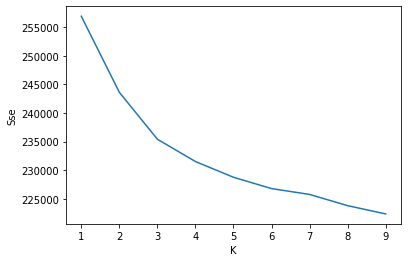

In [ ]:
elbow_method(dataset_pca)

As we can see from the graph, we have a small "elbow" in correspondence of k=3 so from this method we get that the best number of cluster for our dataset is 3.

Find the best number of cluster using the Silhouette method

In [ ]:
silhouette_method(dataset_pca)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  import sys


[0,
 0.09691422328171781,
 0.09997903077812927,
 0.05007406494908358,
 0.09660711170186607,
 0.06072515793317802,
 0.057548824481635695,
 0.0572855284993756,
 0.06154575426620928]

The silhouette method tells us that the best number of cluster is 3.
Since we got the same from Elbow method, we decide to use that number of cluster for our k-means

In [ ]:
centroids,clusters,points_in_cl = k_means(dataset_pca,3)
clusters

array([2, 2, 2, ..., 1, 2, 0])

### Es 2.3.4 

Run the k-means ++ on the dataset

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3,init='k-means++').fit(dataset_pca)
kmeans.labels_

array([2, 2, 2, ..., 1, 2, 0], dtype=int32)

Compare the results obtained, paying attention that same clusters have same value as identifier.
Knowing that, we just execute this script to see how many sample results to be in the same cluster for both the algorithms.

In [ ]:
c=0
for i in range(len(clusters)):
  if clusters[i]==kmeans.labels_[i]:
    c+=1
print(c)
print(len(dataset_pca))

13126
13129


So as we can see, the result obtained is really good because only 3 samples are in different clusters and on the other hand, 13126 sample on 13129 total sample result to be in the same cluster (for our k-means algorithm and for k-means++ algorithm already implemented)

## Es 2.4

For first create a new dataframe from the original one (with nan values) with the new column that indicates in which cluster each track belongs

In [ ]:
newdf = pd.concat([dfna,pd.DataFrame(clusters, columns = ['cluster'])],axis = 1)

In [ ]:
newdf['track_language_code'] = tracks['track_language_code'].fillna(np.NaN)

In [ ]:
newdf['track_genre_top'] = tracks['track_genre_top']

Just open this file:

In [ ]:
newdf = pd.read_csv('/content/drive/MyDrive/df_country.csv')

#### Album Type Pivot Table 

In [ ]:
album_table = pd.crosstab(newdf['album_type'],newdf['cluster'],rownames=['Album Type'], colnames=['N° Cluster']).apply(lambda r: round(r/r.sum()*100,2), axis=0)
album_table

N° Cluster,0,1,2
Album Type,,,
Album,61.97,87.81,72.91
Contest,0.06,0.11,0.18
Live Performance,13.79,4.06,10.03
Radio Program,22.77,7.35,15.58
Single Tracks,1.41,0.67,1.30


As we can see from this pivot table most of the songs in each of our clusters were part of an album. The cluster "1" is the one with the highest percentage of album's songs (87.81%). In cluster "0" we have the highest percentage of songs from a radio program (22.77%) and Live Performance's songs (13.79%) and the lowest percentage of album's songs (61.97%). There are just few songs in each cluster that are from singles (respectively 1.41%, 0.67% and 1.30%). Contest's song are nearly absent

#### Song's Language Pivot Table

In [ ]:
lang_table = pd.crosstab(newdf['track_language_code'],newdf['cluster'],rownames=['Language'], colnames=['N° Cluster']).apply(lambda r: round(r/r.sum()*100,2), axis=0)
lang_table

N° Cluster,0,1,2
Language,,,
ar,0.06,0.10,0.09
az,0.00,0.04,0.00
bg,0.04,0.08,0.03
bm,0.00,0.02,0.00
de,0.02,0.02,0.06
el,0.06,0.08,0.00
en,98.15,97.12,97.95
es,0.84,0.60,0.74
eu,0.00,0.02,0.00


As we can see the most common language for all the songs in each cluster is "en" language (that covers respectively 98.15%,	97.12%,	97.95%). The second most common language for cluster "0" is "es" (0.84%); for cluster "1" is "es" (0.60%) and for cluster "2" is "es" (0.74%). 

#### Artist Country Pivot Table



In [ ]:
!pip install reverse_geocoder

In [ ]:
import reverse_geocoder as rg
import math

Those codes were used to create our feature "artist_conutry" but it is long to run. To check the code just open the dataframe file below

In [ ]:
# code to prepare our coordinates to be converted in countries
latitude = newdf['artist_latitude']
longitude = newdf['artist_longitude']
coord = zip(latitude,longitude)
coord = list(coord)

In [ ]:
# code to convert coordinates in countries
country = list()
for i in tqdm(range(len(coord))):
  if math.isnan(coord[i][0]):
    country.append(np.NaN)
  else:
    results = rg.search(coord[i])
    country.append(list(results[0].items())[5][1])

100%|██████████| 13129/13129 [31:37<00:00,  6.92it/s]


In [ ]:
country_table = pd.crosstab(newdf['artist_country'],newdf['cluster'],rownames=['Artist Country'], colnames=['N° Cluster']).apply(lambda r: round(r/r.sum()*100,2), axis=0)
country_table

N° Cluster,0,1,2
Artist Country,,,
AR,0.06,0.75,2.11
AT,0.30,0.51,1.00
AU,0.63,0.31,0.11
BE,0.36,1.39,1.95
BM,0.06,0.37,0.00
BR,0.45,1.63,1.11
BY,0.00,0.00,0.06
CA,1.78,2.24,2.06
CH,0.06,0.88,0.44


As we can see in the previous table, for each cluster the highest artist's location percentage is US (with respectively 69.14%, 43.48% and 57.79%). For Cluster 0 the second highest percentage is "GB". For Cluster 1 higher percentages are for "GB" (11.58%) , "IT" (5.47%) and "RU" (2.34%). For Cluster 2 the second highest percentage is for "GB" (6.28%). 

#### Song's Duration Pivot Table

In [ ]:
# setting bins for the conversion from quantitative to qualitative
min = newdf['track_duration'].min()
max = newdf['track_duration'].max()
first = newdf['track_duration'].describe()[4]
second = newdf['track_duration'].describe()[5]
third = newdf['track_duration'].describe()[6]
bins = [min, first, second, third, max]
categ_dur = pd.cut(newdf['track_duration'], bins, include_lowest=True, labels=['short','medium','long','really long'])

In [ ]:
durat_table = pd.crosstab(categ_dur,newdf['cluster'],rownames=['Track Duration'], colnames=['N° Cluster']).apply(lambda r: round(r/r.sum()*100,2), axis=0)
durat_table

N° Cluster,0,1,2
Track Duration,,,
short,35.14,17.85,21.55
medium,26.86,22.76,26.59
long,20.84,29.46,23.59
really long,17.16,29.93,28.27


The "track duration" was a numeric variable that we converted in a qualitative variable. The transformation was made dividing the range in four classes considering  quartiles of the distribution. For this reason is not suprising that each category in each cluster has nearly the same percentage (near 25%). As we can see "Cluster 2" is made mostly of "really long" tracks (28.27%). "Cluster 0" is the one with the highest percentage of "short" song(35.14%); it has also the highest percetage between all the cluster for "medium" songs (26.86%) and the lowest for "really long" tracks (17.16%). "Cluster 1" is the one with the lowest percentage for short tracks between all clusters (17.85%); it has also the highest percentage for "long" and "really long" tracks (29.46% and 29.93%). 

#### Song's Danceability Pivot Table

Since it's a numerical variable we have to categorize these values too. But in this case we don't calculate the min and max values because we already know that this feature is in an interval [0,1]

In [ ]:
bins = [0, 0.25, 0.50, 0.75, 1]
categ_dance = pd.cut(newdf['audio_features_danceability'], bins, include_lowest=True, labels=['0-0.25','0.25-0.5','0.5-0.75','0.75-1'])

In [ ]:
danceability_table = pd.crosstab(categ_dance,newdf['cluster'],rownames=['Danceability'], colnames=['N° Cluster']).apply(lambda r: round(r/r.sum()*100,2), axis=0)
danceability_table

N° Cluster,0,1,2
Danceability,,,
0-0.25,19.93,2.52,14.29
0.25-0.5,50.01,23.73,51.01
0.5-0.75,26.84,52.32,32.69
0.75-1,3.21,21.42,2.01


As we can see in the previous pivot table "Cluster 1" is the cluster with the highest percentage of '0.75-1' Danceability (21.42%) and the lowest percentage of '0-0.25' Danceability (2.52%). So, assuming that value 0 means not danceable and 1 means very danceable, cluster 1 includes all the most danceable tracks. "Cluster 2" instead is the one with the less danceable tracks, with one of the lowest percentage for '0.75-1' Danceability (2.01%) and the highest for '0-0.25' Danceability (14.29%). 

#### Audio Features Energy Pivot Table

Since it's a numerical variable we have to categorize these values too. But in this case we don't calculate the min and max values because we already know that this feature is in an interval [0,1]

In [ ]:
bins = [0, 0.25, 0.50, 0.75, 1]
categ_energy = pd.cut(newdf['audio_features_energy'], bins, include_lowest=True, labels=['0-0.25','0.25-0.5','0.5-0.75','0.75-1'])

Now we can effectively create the correspondent pivot table

In [ ]:
energy_table = pd.crosstab(categ_energy,newdf['cluster'],rownames=['Energy'], colnames=['N° Cluster']).apply(lambda r: round(r/r.sum()*100,2), axis=0)
energy_table

N° Cluster,0,1,2
Energy,,,
0-0.25,3.57,7.83,54.52
0.25-0.5,14.09,29.64,33.74
0.5-0.75,31.72,38.57,10.52
0.75-1,50.62,23.96,1.22


Assume that 0 is "Zero Energy Track" and 1 is "Max Energy Track. "Cluster 2" is the one with the highest percentage of Low Energy Songs (54.52%) and the lowest for High Energy Tracks (1.22%). "Cluster 0" is the one with the highest percentage of High Energy Songs (50.62%). "Cluster 1" is the one with a nearly similar percentage for each category except "0-0.25" songs, that means that in average this cluster has a slightly higher value for Track's Energy w.r.t. the average. 

#### Song's Instrumentalness Pivot Table

Since it's a numerical variable we have to categorize these values too. But in this case we don't calculate the min and max values because we already know that this feature is in an interval [0,1]

In [ ]:
bins = [0, 0.25, 0.50, 0.75, 1]
categ_instrum = pd.cut(newdf['audio_features_instrumentalness'], bins, include_lowest=True, labels=['0-0.25','0.25-0.5','0.5-0.75','0.75-1'])

Now we can effectively create the correspondent pivot table

In [ ]:
instrumentalness_table = pd.crosstab(categ_instrum,newdf['cluster'],rownames=['Instrumentalness'], colnames=['N° Cluster']).apply(lambda r: round(r/r.sum()*100,2), axis=0)
instrumentalness_table

N° Cluster,0,1,2
Instrumentalness,,,
0-0.25,16.91,30.16,22.63
0.25-0.5,5.67,5.97,5.59
0.5-0.75,11.36,11.49,8.34
0.75-1,66.06,52.39,63.45


Assume 0 is "No Instrumentalness" and 1 is "Max instrumentalness between all songs". As we can see all clusters have the highest percentage on the "0.75-1" category (respectively 66.06%, 52.39%, 63.45%) that means that most of the tracks have an high instrumentalness score. "Cluster 1" is the one with the highest percentage of the lowest category for Instrumentalness score (30.16%). "Cluster 0" is the one with more high instrumentalness score w.r.t. all the other clusters

### Es 2.4.6

We need to compute the pivot table for the genre ("track_genre_top") 

In [ ]:
genre_table = pd.crosstab(newdf['track_genre_top'],newdf['cluster'],rownames=['Genre'], colnames=['N° Cluster']).apply(lambda r: round(r/r.sum()*100,2), axis=0)
genre_table

N° Cluster,0,1,2
Genre,,,
Blues,0.52,0.60,0.87
Classical,1.56,2.13,1.88
Country,0.92,0.67,1.79
Easy Listening,0.03,0.00,0.00
Electronic,14.43,13.71,15.09
Experimental,14.98,15.80,17.66
Folk,7.61,9.45,7.06
Hip-Hop,6.02,6.32,5.54
Instrumental,1.25,1.63,1.74


As we can see from the previous table the most representative genre for each group is:
- Cluster 0: Rock Genre (39.03%)
- Cluster 1: Rock Genre (37.16%)
- Cluster 2: Rock Genre (36.94%)

We can see that rock genre is the most representive genre for all the cluster. Cluster 1 has also an high percentage of Electronic Music (13.71%) and Folk music (9.45%). Cluster 0 presents the highest percentage of rock tracks and an high percentage of electronic tracks (14.43%).

## Es 2.4.7

Execute your K-means++ Analysis again, but don't use the variables from echonest.csv.

### Create the dataset 

In [ ]:
df_7 = pd.merge(feat,tracks, on = 'track_id') # merge the 2 dataframe (features and tracks)

In [ ]:
df_7.shape # we obtains around 100k rows, as we wanted

(106574, 571)

In [ ]:
df_7.head()

### Perform the dimensionality reduction

#### Preprocessing the dataset

Cleaning all features with too many "na" values (all the ones with more than 10%)

In [ ]:
df_7 = df_7.dropna(axis=1,thresh=int(0.9*df_7.shape[0]))  ## drop all columns with more than 10% of nan value

In [ ]:
df_7na = df_7.fillna(np.NaN)    #this will be used for the Cluster-Analysis
df_7 = df_7.fillna(0)           #this will be used for the PCA

In [ ]:
# Checking if it contains near 13000 rows
print(df_7na.shape)
print(df_7.shape)

(106574, 549)
(106574, 549)


#### Apply PCA to reduce the dimensionality

In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [ ]:
typo=dict(df_7.dtypes)

In [ ]:
# Create two list with respectively the names of float and non-float variables
features = list()
target = list()
for f in typo:
  if typo[f] == 'float64':
    features.append(f)
  else:
    target.append(f)

In [ ]:
fe = df_7.select_dtypes(include=['float64']) #only float

In [ ]:
import numpy as np

# Create correlation matrix
corr_matrix = fe.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features 
fe.drop(to_drop, axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
fe.shape

(106574, 441)

In [ ]:
# Creates two arrays with the values respectively of float variables and non-float variables
x = fe.values
y = df_7.loc[:,target].values

In [ ]:
# Standardize numeric variables
x = StandardScaler().fit_transform(x)

In [ ]:
colx = ['PC' + str(i) for i in range(1,70)]

In [ ]:
# Principal Component Analysis; we create 69 new variables from the original 780
pca = PCA(n_components=69)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns=colx)

In [ ]:
# Creates a dataframe with our Principal Components and old non-float variables
finalDf_reduced = pd.concat([principalDf, pd.DataFrame(y, columns=target)], axis = 1)

In [ ]:
# Checks if the explained data is near 70%
sum(pca.explained_variance_ratio_)

0.7450010614778338

#### Find the optimal number of clusters

Using elbow method

In [ ]:
finalDf_pca = finalDf_reduced.loc[:,:'PC69']
finalDf_pca = finalDf_pca.loc[:, finalDf_pca.columns != 'Unnamed: 0']
finalDf_pca = finalDf_pca.to_numpy().tolist()

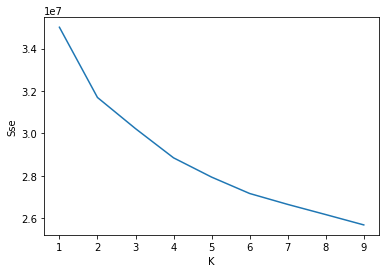

In [ ]:
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans


sse=[] # list that will contain the sum of squared errors for each k
for num_clusters in range(1,10):
  sum_dist=0
  kmeans = KMeans(n_clusters=num_clusters,init='k-means++').fit(finalDf_pca) # apply k-means++ algorithm with every k
  sse.append(kmeans.inertia_) 
  
plt.xlabel('K')
plt.ylabel('Sse')
plt.plot(range(1,10),sse) 

The elbow seems to be in correspondence of k=4, so the best number of cluster suggested by elbow method is 4

#### Execute k-means ++

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4,init='k-means++').fit(finalDf_pca)
kmeans.labels_

array([3, 3, 3, ..., 2, 2, 2], dtype=int32)

In [ ]:
y = df_7na.loc[:,target]

In [ ]:
kmeandf = pd.concat([fe, pd.DataFrame(y, columns=target)], axis = 1)

In [ ]:
kmeandf['cluster'] = kmeans.labels_

### Album Type Pivot Table

In [ ]:
album_table = pd.crosstab(kmeandf['album_type'],kmeandf['cluster'],rownames=['Album Type'], colnames=['N° Cluster']).apply(lambda r: round(r/r.sum()*100,2), axis=0)
album_table

N° Cluster,0,1,2,3
Album Type,,,,
Album,87.06,88.64,83.11,93.40
Contest,0.02,0.01,0.01,0.02
Live Performance,5.38,3.92,6.99,2.41
Radio Program,6.62,5.42,9.14,3.33
Single Tracks,0.92,2.02,0.75,0.84


As in the previous analysis the highest percentage for each cluster is album's songs with respectevely (87.06%, 88.64%, 83.11% and 93.40%). For cluster 2 we have also the highest percentage for radio programs between all clusters (9.14%)

### Song's Language Pivot Table

In [ ]:
kmeandf['track_language_code'] = tracks['track_language_code']

In [ ]:
lang_table = pd.crosstab(kmeandf['track_language_code'],kmeandf['cluster'],rownames=['Album Type'], colnames=['N° Cluster']).apply(lambda r: round(r/r.sum()*100,2), axis=0)
lang_table

N° Cluster,0,1,2,3
Album Type,,,,
ar,0.24,0.00,0.03,0.03
az,0.03,0.00,0.02,0.00
bg,0.19,0.00,0.00,0.00
bm,0.03,0.00,0.00,0.00
cs,0.03,0.00,0.07,0.00
de,1.23,0.17,0.20,0.20
ee,0.00,0.17,0.08,0.00
el,0.05,0.09,0.07,0.00
en,93.98,97.25,95.70,93.77


With respect to the previous analysis we can see a higher percentage for english language for each cluster. Also "es"language, that in the previous analysis was for most of cluster the second highest, hardly overcome 1% in each cluster. 

### Song's Duration Pivot Table

In [ ]:
kmeandf['track_duration']

In [ ]:
# setting bins for the conversion from quantitative to qualitative
min = kmeandf['track_duration'].min()
max = kmeandf['track_duration'].max()
first = kmeandf['track_duration'].describe()[4]
second = kmeandf['track_duration'].describe()[5]
third = kmeandf['track_duration'].describe()[6]
bins = [min, first, second, third, max]
categ_dur = pd.cut(kmeandf['track_duration'], bins, include_lowest=True, labels=['short','medium','long','really long'])

In [ ]:
dur_table = pd.crosstab(categ_dur,kmeandf['cluster'],rownames=['Album Type'], colnames=['N° Cluster']).apply(lambda r: round(r/r.sum()*100,2), axis=0)
dur_table

N° Cluster,0,1,2,3
Album Type,,,,
short,25.52,53.61,26.94,14.51
medium,24.70,18.22,27.81,23.26
long,23.81,14.08,23.89,30.34
really long,25.98,14.08,21.36,31.89


With respect to the previous analysis nothing is really changed except number of clusters. All the percentages are again near 25% due to the choice of the bins in corrispondence of quartiles. Cluster 3 has the highest percentage for really long songs (31.89%)

In [ ]:
kmeandf.to_csv('/content/drive/MyDrive/df_7.csv')

### Track Genre Pivot Table

In [ ]:
kmeandf['track_genre_top'] = tracks['track_genre_top']

In [ ]:
genre_table = pd.crosstab(kmeandf['track_genre_top'],kmeandf['cluster'],rownames=['Genre'], colnames=['N° Cluster']).apply(lambda r: round(r/r.sum()*100,2), axis=0)
genre_table

N° Cluster,0,1,2,3
Genre,,,,
Blues,0.49,0.00,0.17,0.16
Classical,10.64,0.09,0.33,0.22
Country,0.56,0.16,0.43,0.28
Easy Listening,0.05,0.05,0.01,0.10
Electronic,9.70,17.37,12.40,35.79
Experimental,22.35,33.26,18.44,21.36
Folk,16.60,1.47,3.58,1.73
Hip-Hop,0.75,2.75,4.90,16.64
Instrumental,10.13,3.45,2.92,1.82


W.r.t. the previous analysis we can see some differences: rock genre now dominates only two of four cluster (but before was dominating all three clusters) and experimental genre is appeared with very high percentages for all thre four clusters (in cluster 0 has the highest percentage, 22.35%). Electronic genre has again an high percentage, especially in the cluster 3 (35.79%). 

### Track's Listens Pivot Table

In [ ]:
# setting bins for the conversion from quantitative to qualitative
min = kmeandf['track_listens'].min()
max = kmeandf['track_listens'].max()
first = kmeandf['track_listens'].describe()[4]
second = kmeandf['track_listens'].describe()[5]
third = kmeandf['track_listens'].describe()[6]
bins = [min, first, second, third, max]
categ_dur = pd.cut(kmeandf['track_listens'], bins, include_lowest=True, labels=['few','medium','lot','masterpiece'])

In [ ]:
dur_table = pd.crosstab(categ_dur,kmeandf['cluster'],rownames=['Album Type'], colnames=['N° Cluster']).apply(lambda r: round(r/r.sum()*100,2), axis=0)
dur_table

N° Cluster,0,1,2,3
Album Type,,,,
few,19.69,32.36,28.23,23.65
medium,21.23,28.81,26.87,24.66
lot,25.10,22.51,24.47,26.18
masterpiece,33.98,16.33,20.43,25.51


As we can see from the previous table all the percentages are near the same value (25%) but we can see the highest percentage in all the pivot table in the masterpieces in cluster 0 that has a percentage equal to (33.98%). All the other cluster has nearly the same percentages and this is expected considering that we have converted a quantitative feature in a qualitative feature using for the bins quartiles of the distribution. 

## Conclusions

In the end we can conclude the following things: dimensionality reduction and cluster reduction are both methods that, given a more efficient representation, take away part of the information. As we can compare from the dimensionality reduction, mantaining the same number of principal component the remaining explained information is higher for the dimensionality reduction on the dataset with more "samples" (74% against 70% for the PCA on the restricted dataset). Considering instead cluster reduction, clustering on more data (near 100000 rows) resolves in a higher loss of information w.r.t. clusterization on a smaller data (13000 rows) as we can see from both elbow graphics. We need to consider also that methods differ but as we have seen for the restricted dataset we have seen the "elbow" at cluster number 3, instead of the larger dataset were the elbow method suggest use to take 4 clusters. In the end, considering all the previous comments, we have preferred a larger dataset with less features instead of one with more features and less "samples", but is not so surprising considering that all the analysis are better with more and more data taken. 

# Es 3

Given a list $a$ and an integer $s$, this algorithm gives us all the different pairs in $a$ whose sum is equal to $s$

In [ ]:
def pairs(a, s):
    ris = []
    for i in range(len(a)):
        for j in range(i+1, len(a)):
            if a[i]+a[j] == s:
                ris.append((a[i], a[j]))
    return ris

Example of application

In [ ]:
pairs([7, -2, 8, 2, 6, 4, -7, 2, 1, 3, -3], 4)

[(7, -3), (-2, 6), (2, 2), (1, 3)]